## Problem Set 03
### AST 8110, Fall 2022
##### Tyler Barna

In [1]:
## Importing packages (some of these may not be useful)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import time
#bigstart = time.time()
#import numba

import sys
import os
import astropy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import random

from numpy.linalg import norm ## to calculate magnitude of vector

from tqdm import tqdm
from scipy.stats import binned_statistic as binstat
from scipy.integrate import quad, dblquad ## to integrate
from scipy.signal import argrelextrema as extrema ## to find local extrema (as index)


## Set Seed
random.seed(8110)


All quantities below are assumed to be project on the plane of the sky.

The mass distribution in the lens is assymmetric, centered on $(0,0)$, and its raidal density profile is given by
\begin{equation}
\kappa = \kappa_{0} \left( \frac{|\vec{\theta}| + \theta_{0}}{\theta_{0}} \right)^{m}
\end{equation}
where $\kappa_{0}=30$, $\theta_{0}=1$, and $m=-3.2$. The profile is truncated at $\theta_{max}=5$ such that $\kappa(\theta>\theta_{max})=0$.

A source is placed on the positive $\theta_{x}$ axis at $\theta_{x}=\beta=2$ from the origin. Because of symmetry, all images will be located on the $\theta_{x}$ axis.

## (a) Time Delay Surface

\begin{equation}
T\left( \theta_{x}\right) \propto
\frac{1}{2} \left( \theta_{x} - \beta \right)^{2}
- \frac{1}{\pi} \int \text{d} \theta_{x}^{\prime} \text{d} \theta_{y}^{\prime} \kappa\left( \theta_{x}^{\prime} , \theta_{y}^{\prime}  \right)
\text{ln} \sqrt{\left( \theta_{x} - \theta_{x}^{\prime} \right)^{2} + \left( \theta_{y}^{\prime} \right)^{2}}

\end{equation}

In [2]:
## define constants
kappa_0 = 30
theta_0 = 1
theta_max = 5
m = -3.2
beta = 2

In [3]:
## define radial density profile with x and y just being the components of the vector
## norm just calculates the magnitude of the vector
def rdp(x,y):
    theta_vec = norm(np.array([x,y]))
    if theta_vec < theta_max: 
        density = kappa_0 * ( ( theta_vec + theta_0)/(theta_0) )**m
    else:
        density = 0
    return(density)

## define integrand as a function of theta_x

x_lim = (-theta_max,theta_max)
y_lim = (-theta_max,theta_max)

def integrand(theta_x):
    return dblquad(lambda x,y: rdp(x,y) * np.log( np.sqrt((theta_x - x)**2 + y**2) ),
                   x_lim[0], x_lim[1], 
                   lambda y: y_lim[0], lambda y: y_lim[1],
                   epsrel=5e-2)[0]


## define function where theta_x is theta_x and x and y are the prime components of the integrand 

delay = lambda theta_x: 0.5 * (theta_x - beta)**2 - (1/np.pi) * integrand(theta_x)
delay = np.vectorize(delay) ## vectorize the function so I can use it on arrays

In [4]:
## define a linspace of theta_x values and calculate the time delay surface
theta_space = np.linspace(-theta_max-1,theta_max+1,500)
tds = delay(theta_space)

In [5]:
## find local extrema
minima = extrema(tds, np.less)[0]
maxima = extrema(tds, np.greater)[0]

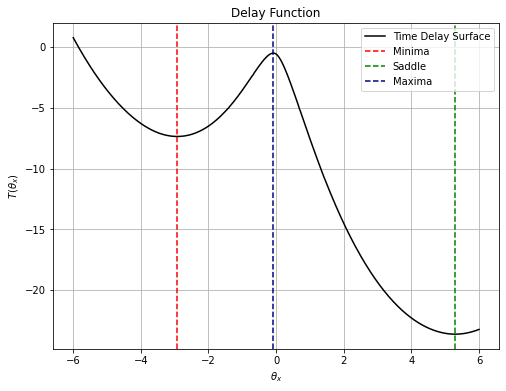

In [6]:
## plot the delay function
fig, ax = plt.subplots(figsize=(8,6),facecolor='w')
ax.plot(theta_space, tds,color='black',label='Time Delay Surface')

## plot the local extrema
ax.axvline(theta_space[minima[0]], 
           color='r', linestyle='--',
           label='Minima')
ax.axvline(theta_space[minima[1]], 
           color='g', linestyle='--',
           label='Saddle')
ax.axvline(theta_space[maxima[0]], 
           color='navy', linestyle='--',
           label='Maxima')

## general plot settings
ax.grid()
ax.set_xlabel(r'$\theta_x$')
ax.set_ylabel(r'$T(\theta_x)$')
ax.legend();
ax.set_title('Delay Function'); 

## (b) Lens Equation 

The lens equation can be written as

\begin{equation}
\vec{\theta} - \vec{\beta} = \vec{\alpha}
\end{equation}

where $\vec{\alpha}$ is the deflection angle. 

The magnitude of the deflection angle can be calculated as

\begin{equation}
\alpha = \frac{M\left( \leq \theta \right)}{\pi \theta}
\end{equation}

where $M\left( \leq \theta \right)$ is the mass enclosed within a radius $\theta$ of the origin.

The deflection angle can be rewritten in terms of the radial density profile as

\begin{equation}
\alpha \left(\theta \right) = \frac{ 2 \pi \int_{0}^{\theta} \text{d} \theta^{\prime} \kappa\left( \theta^{\prime} \right) \theta^{\prime}}{\pi \theta}
\end{equation}

Plotting

(i) $\theta - \beta$ vs. $\theta$ 

(ii) $\alpha$ vs. $\theta$

In [7]:
## define rdp wrt magnitude of vector since we don't care about the components in this case
def rdp_mag(theta):
    if np.abs(theta) < theta_max: 
        density = kappa_0 * ( ( np.abs(theta) + theta_0)/(theta_0) )**m
    else:
        density = 0
    return(density)

## Integrate the radial density profile to get the total mass
def mass(theta):
    return quad(lambda theta: rdp_mag(theta)*2*np.pi * theta, 
                0, theta,
                epsrel=5e-2)[0]

alpha = lambda theta: mass(theta)/(np.pi*theta)
alpha = np.vectorize(alpha) 

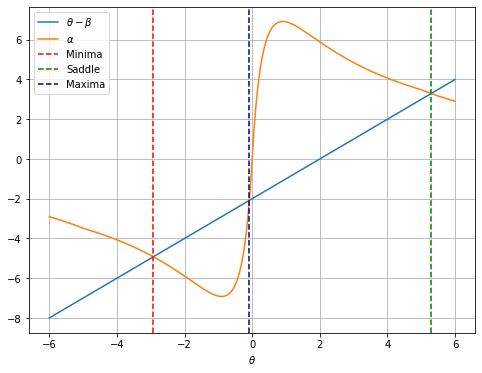

In [8]:
## plot theta - beta vs theta and alpha vs theta
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(theta_space, theta_space - beta, 
        label=r'$\theta - \beta$')
ax.plot(theta_space, alpha(theta_space), 
        label=r'$\alpha$')
#ax.plot(theta_space, tds, label='Time Delay Surface')

## plot the local extrema found from part a
ax.axvline(theta_space[minima[0]], 
           color='r', linestyle='--',
           label='Minima')
ax.axvline(theta_space[minima[1]], 
           color='g', linestyle='--',
           label='Saddle')
ax.axvline(theta_space[maxima[0]], 
           color='navy', linestyle='--',
           label='Maxima')


## general plot settings
ax.grid()
ax.set_xlabel(r'$\theta$');
ax.legend()
plt.show();

The positions of the images are consistent between both methods